In [109]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas
import pandas as pd
import numpy
import numpy as np

import root_numpy

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

from rep.estimators import XGBoostClassifier

from bayes_opt import BayesianOptimization

import theano
import theano.tensor as T

import lasagne

import sys
from six.moves import cPickle as pickle


def load_nn(nn, filename):
    kwargs = {}
    if sys.version_info >= (3,):
        kwargs = {'encoding': 'latin1'}

    with open(filename, 'rb') as fin:
        saved_params = pickle.load(fin, **kwargs)

    lasagne.layers.set_all_param_values(nn, saved_params)
    return nn

def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
def batch_inputs(inputs, batchsize):
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [110]:
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
full_data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_1000000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))


In [111]:
def dphi(phi1, phi2):
    "Return the angular difference in the range [-pi,pi)"
    dphi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return dphi

def dr(eta1, eta2, phi1, phi2):
    "Return the eta-phi distance"
    return np.sqrt((eta1-eta2)**2 + dphi(phi1,phi2)**2)

In [112]:
features = [u'lepton_pt', u'lepton_eta', u'lepton_phi', u'mem_pt', u'mem_phi',
       u'jet1_pt', u'jet1_eta', u'jet1_phi', u'jet1_btag', u'jet2_pt',
       u'jet2_eta', u'jet2_phi', u'jet2_btag', u'jet3_pt', u'jet3_eta',
       u'jet3_phi', u'jet3_btag', u'jet4_pt', u'jet4_eta', u'jet4_phi',
       u'jet4_btag', u'm_jj', u'm_jjj', u'm_lv', u'm_jlv', u'm_bb', u'm_wbb',
       u'm_wwbb']
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

# a list of all proper objects and all objects + MET
real_objects = ['lepton', 'jet1', 'jet2', 'jet3', 'jet4']
objects = real_objects + ['mem']

In [149]:
def add_features(data):
    data['ht'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt']
    data['meff'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt'] + data['lepton_pt'] + data['mem_pt']
    data['rt'] = data['meff'] / data['m_wwbb']
    data['delta_m'] = np.abs(data['m_jjj'] - data['m_jlv'])
    
    variables = ['ht', 'meff', 'rt', 'delta_m']
    
    data['dr_j12'] = dr(data['jet1_eta'], data['jet2_eta'], data['jet1_phi'], data['jet2_phi'])
    data['dr_j34'] = dr(data['jet3_eta'], data['jet4_eta'], data['jet3_phi'], data['jet4_phi'])
    
    variables += ['dr_j12', 'dr_j34']
    
    for i in [1,2,3,4]:
        data['dr_lj%d' % i] = dr(data['jet%d_eta' % i], data['lepton_eta'], data['jet%d_phi' % i], data['lepton_phi'])
        data['dphi_met_j%d' % i] = np.abs(dphi(data['mem_phi'], data['jet%d_phi' % i]))

        variables += ['dr_lj%d' % i, 'dphi_met_j%d' % i]
        
    data['max_dr_lj'] = np.maximum(np.maximum(data['dr_lj1'], data['dr_lj2']),
                                   np.maximum(data['dr_lj3'], data['dr_lj4']))
    data['min_dr_lj'] = np.minimum(np.minimum(data['dr_lj1'], data['dr_lj2']),
                                   np.minimum(data['dr_lj3'], data['dr_lj4']))   

    data['max_dphi_met_j'] = np.maximum(np.maximum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.maximum(data['dphi_met_j3'], data['dphi_met_j4']))
    data['min_dphi_met_j'] = np.minimum(np.minimum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.minimum(data['dphi_met_j3'], data['dphi_met_j4']))

    variables += ['max_dr_lj', 'min_dr_lj', 'max_dphi_met_j', 'min_dphi_met_j']

    data['max_jet_pt'] = np.maximum(np.maximum(data['jet1_pt'], data['jet2_pt']),
                                    np.maximum(data['jet3_pt'], data['jet4_pt']))
    data['min_jet_pt'] = np.minimum(np.minimum(data['jet1_pt'], data['jet2_pt']),
                                    np.minimum(data['jet3_pt'], data['jet4_pt']))       
    
    variables += ['max_jet_pt', 'min_jet_pt']
    
    for obj in real_objects:
        data['%s_abs_eta' % obj] = np.abs(data['%s_eta' % obj])
        variables.append('%s_abs_eta' % obj)
        
        for obj2 in ['lepton']:
            if obj == obj2:
                continue
            
            dphi_name = "dphi_%s_%s" % (obj, obj2)
            deta_name = "deta_%s_%s" % (obj, obj2)
            
            data[dphi_name] = np.abs(dphi(data['%s_phi' % obj], data['%s_phi' % obj2]))
            data[deta_name] = np.abs(data['%s_eta' % obj] - data['%s_eta' % obj2])
            
            variables += [dphi_name, deta_name]
    
    return variables

new_features = add_features(data)
add_features(full_data)
add_features(test)

training_data, validation_data = train_test_split(data, random_state=11, train_size=0.8)
full_train, full_valid = train_test_split(full_data, random_state=11, train_size=0.8)

signal = data[data.target == 1]
background = data[data.target == 0]

bad_features = [
    "jet4_btag", 
    "jet3_btag", 
    "jet1_btag",
    "jet2_btag",
    "jet1_eta",
    "jet2_eta",
    "jet3_eta",
    "jet4_eta",
    "lepton_eta",
]

selected_features = features + new_features
selected_features = list(set(selected_features) - set(bad_features))


In [185]:
len(selected_features)

52


tab completion not implemented for this context


In [114]:
from sklearn.base import BaseEstimator
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

class CVEstimator(BaseEstimator):
    def __init__(self, cv, est_type, args={}):
        self.cv = cv
        self.estimator_type = est_type
        self.estimator_args = args
        
        self.estimators = [est_type(**args) for _ in xrange(self.cv)]
        
    def fit(self, x, y):
        skf = StratifiedKFold(y.copy(), self.cv)
        
        self.scores = []
        
        for i, train_test in enumerate(skf):
            est = self.estimators[i]
            train, test = train_test
            
            est.fit(x.iloc[train], y.iloc[train])
            
            pred = est.predict_proba(x.iloc[test])[:,1]
            score = roc_auc_score(y.iloc[test], pred)
            self.scores.append(score)
            
        # calculate feature importance
        score_norm = 1 / sum(self.scores)
        self.feature_importances_ = []
        
        for i in xrange(len(self.estimators[0].feature_importances_)):
            imp_sum = 0
            for j, est in enumerate(self.estimators):
                imp_sum += self.scores[j] * est.feature_importances_[i]
            
            self.feature_importances_.append(imp_sum * score_norm)
        
        return self
    
    def predict_proba(self, x):
        pred = None
        
        for est in self.estimators:
            this_pred = est.predict_proba(x)
            if pred is None:
                pred = this_pred
            else:
                pred += this_pred
        
        pred /= self.cv
        return pred

In [115]:
final_clf = joblib.load("cv6_xgboost_gridopt_train10m.clf")

In [130]:
all_features

[u'lepton_pt',
 u'lepton_eta',
 u'lepton_phi',
 u'mem_pt',
 u'mem_phi',
 u'jet1_pt',
 u'jet1_eta',
 u'jet1_phi',
 u'jet1_btag',
 u'jet2_pt',
 u'jet2_eta',
 u'jet2_phi',
 u'jet2_btag',
 u'jet3_pt',
 u'jet3_eta',
 u'jet3_phi',
 u'jet3_btag',
 u'jet4_pt',
 u'jet4_eta',
 u'jet4_phi',
 u'jet4_btag',
 u'm_jj',
 u'm_jjj',
 u'm_lv',
 u'm_jlv',
 u'm_bb',
 u'm_wbb',
 u'm_wwbb',
 'ht',
 'meff',
 'rt',
 'delta_m',
 'dr_j12',
 'dr_j34',
 'dr_lj1',
 'dphi_met_j1',
 'dr_lj2',
 'dphi_met_j2',
 'dr_lj3',
 'dphi_met_j3',
 'dr_lj4',
 'dphi_met_j4',
 'max_dr_lj',
 'min_dr_lj',
 'max_dphi_met_j',
 'min_dphi_met_j',
 'max_jet_pt',
 'min_jet_pt',
 'lepton_abs_eta',
 'jet1_abs_eta',
 'dphi_jet1_lepton',
 'deta_jet1_lepton',
 'jet2_abs_eta',
 'dphi_jet2_lepton',
 'deta_jet2_lepton',
 'jet3_abs_eta',
 'dphi_jet3_lepton',
 'deta_jet3_lepton',
 'jet4_abs_eta',
 'dphi_jet4_lepton',
 'deta_jet4_lepton']



In [176]:
input_X = T.matrix("X", dtype="float32")

all_features = features + new_features
num_features = len(all_features)

n_features = len(all_features)

# input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None, num_features]

target_y = T.vector("y", dtype="float32")

import lasagne.layers as L
l_in = InputLayer([None, n_features],input_X,'input layer')

n_hid = 500

l_0 = lasagne.layers.BatchNormLayer(l_in, name="l_0")

l_1 = batch_norm(DenseLayer(l_0,
                num_units=700,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.tanh))

d_1 = dropout(l_1, p=0.15)

l_2 = batch_norm(DenseLayer(d_1,
                num_units=700,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.tanh))

d_2 = dropout(l_2, p=0.15)

l_3 = batch_norm(DenseLayer(d_2,
                num_units=700,
                name='dense2',
                nonlinearity=lasagne.nonlinearities.tanh))

d_3 = dropout(l_3, p=0.15)

l_4 = batch_norm(DenseLayer(d_3,
                num_units=700,
                name='dense3',
                nonlinearity=lasagne.nonlinearities.tanh))

d_4 = dropout(l_4, p=0.15)

l_5 = batch_norm(DenseLayer(d_4,
                num_units=700,
                name='dense4',
                nonlinearity=lasagne.nonlinearities.tanh))

nn = DenseLayer(l_5,num_units=2,
                name='dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)


det_predicted = L.get_output(nn, deterministic=True)
eval_fun = theano.function([input_X], det_predicted[:,1], allow_input_downcast=True, name="eval_NN")

In [177]:
load_nn(nn, "nn8.weights")

L.get_all_params(nn)

[l_0.beta,
 l_0.gamma,
 l_0.mean,
 l_0.inv_std,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 dense0_bn.mean,
 dense0_bn.inv_std,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense1_bn.mean,
 dense1_bn.inv_std,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense2_bn.mean,
 dense2_bn.inv_std,
 dense3.W,
 dense3_bn.beta,
 dense3_bn.gamma,
 dense3_bn.mean,
 dense3_bn.inv_std,
 dense4.W,
 dense4_bn.beta,
 dense4_bn.gamma,
 dense4_bn.mean,
 dense4_bn.inv_std,
 dense_out.W,
 dense_out.b]

In [182]:
def eval_mean(x, nn_weight=0.5):
    print "eval NN"
    nn_prob = np.array([])    
    batchsize = 10000
    for batch in batch_inputs(x[all_features].values, batchsize):
        batch_prob = eval_fun(batch)
        nn_prob = np.append(nn_prob, batch_prob)
 
    print "eval BDT"
    xdg_prob = np.array([])    
    batchsize = 100000
    for batch in batch_inputs(x[selected_features], batchsize):
        batch_prob = final_clf.predict_proba(batch)[:,1]
        xdg_prob = np.append(xdg_prob, batch_prob)
    
    bdt_weight = 1-nn_weight
    
    return (bdt_weight * xdg_prob + nn_weight * nn_prob), nn_prob, xdg_prob

In [87]:
data[features].head(1)

,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,2.000023,57.689522,...,0.877472,-0.256736,0,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.68576


In [ ]:
v_prob, v_nn, v_bdt = eval_mean(full_valid, nn_weight=0.95)

In [ ]:
print "BDT", roc_auc_score(full_valid.target, v_bdt)
print "NN ", roc_auc_score(full_valid.target, v_nn)
print "SUM", roc_auc_score(full_valid.target, v_prob)

In [147]:
%%time

test_proba, test_nn, test_bdt = eval_mean(test, nn_weight=0.95)
test_ids = test.event_id

eval NN
eval BDT
CPU times: user 33min 5s, sys: 15.9 s, total: 33min 21s
Wall time: 28min 47s


In [148]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))

create_solution(test_ids, test_nn, "b_allft_nn95_b95.csv")

/home/jan/work/mlhep/mlhep2016/higgs_kaggle/datasets/b_allft_nn95_b95.csv

In [163]:
mean_prob_valid = 0.95*v_nn + 0.05*v_bdt
fpr, tpr, _ = roc_curve(full_valid.target, mean_prob_valid)

In [174]:
def clf_plots(data, name="Classifier"):
    sig = data[data.target==1]
    bkg = data[data.target==0]
    
    pred_bkg, _, _ = eval_mean(bkg, 0.95)
    pred_sig, _, _ = eval_mean(sig, 0.95)
    
    pred, _, _ = eval_mean(data, 0.95)
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.hist(pred_bkg, label="background", alpha=.5, color="blue", range=(0,1), bins=30)
    plt.hist(pred_sig, label="signal", alpha=.5, color="red", range=(0,1), bins=30)
    plt.title(name + " probability")
    plt.legend(loc="best")
    
    fpr, tpr, _ = roc_curve(data.target, pred)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr,  label=name)
    plt.plot([0, 1], [0, 1], 'k--', label='')
    plt.xlabel('FPR'), plt.ylabel('TPR')
    plt.legend(loc='best')
    
    plt.savefig("plots/clf_roc.pdf")
    plt.show()
    

eval NN
eval BDT
eval NN
eval BDT
eval NN
eval BDT


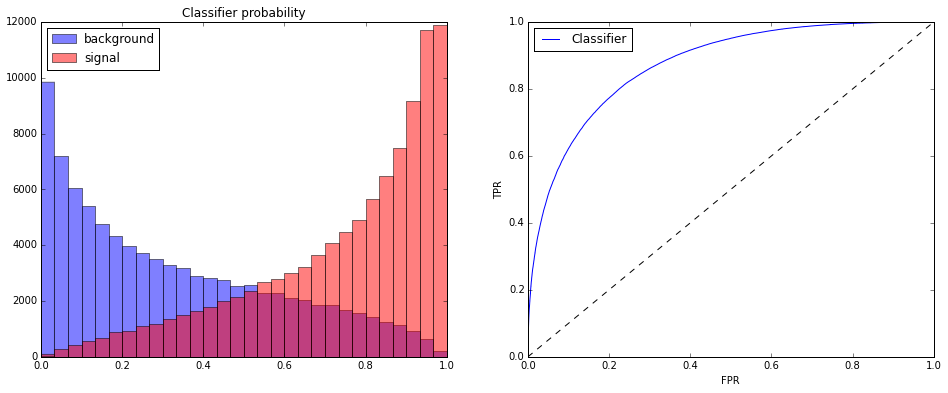

In [175]:
clf_plots(full_valid)